In [214]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

from sklearn.datasets import load_diabetes

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [384]:
sns.set_context('poster')
plt.style.use('seaborn-v0_8-colorblind')

In [18]:
SEED = 123
qasm_sim = AerSimulator()

In [390]:
# Dataset

# x,y = datasets.make_moons(n_samples=100, noise=0.1, random_state=SEED)

x, y = load_diabetes().data, load_diabetes().target
thrs = np.median(y)

In [391]:
# Normalization
for i in range(x.shape[1]):
    x[:,i] = x[:,i] / (np.max(x[:,i]) - np.min(x[:,i]))
    
y[y<thrs] = 0
y[y>=thrs] = 1
    
# x = np.append(x,x, axis=1)
print(x.shape)

(442, 10)


In [392]:
# plt.hist(y)
# x[y < 50,0]
# idx = 3
# thrs = 160
# for idx in range(9):
#     plt.hist(x[y<thrs,idx], density=True)
#     plt.hist(x[y>=thrs,idx], alpha = 0.5, density=True)
#     plt.show()


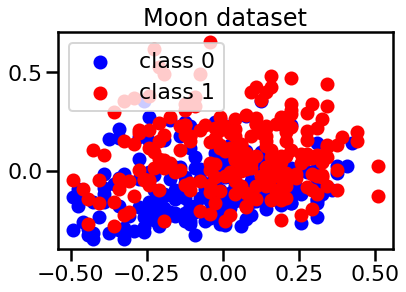

In [393]:

num_classes = 2
num_features = x.shape[1]
x_blue = x[y==0]
x_red = x[y==1]

plt.scatter(x_blue[:,0], x_blue[:,2], c='b', label="class 0")
plt.scatter(x_red[:,0], x_red[:,2], c='r', label="class 1")
plt.title("Moon dataset")
plt.legend()

In [394]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=SEED, stratify=y)

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 353
Test set size:  89


In [477]:
# Data embedding
paulis=["Z"]

/usr/local/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


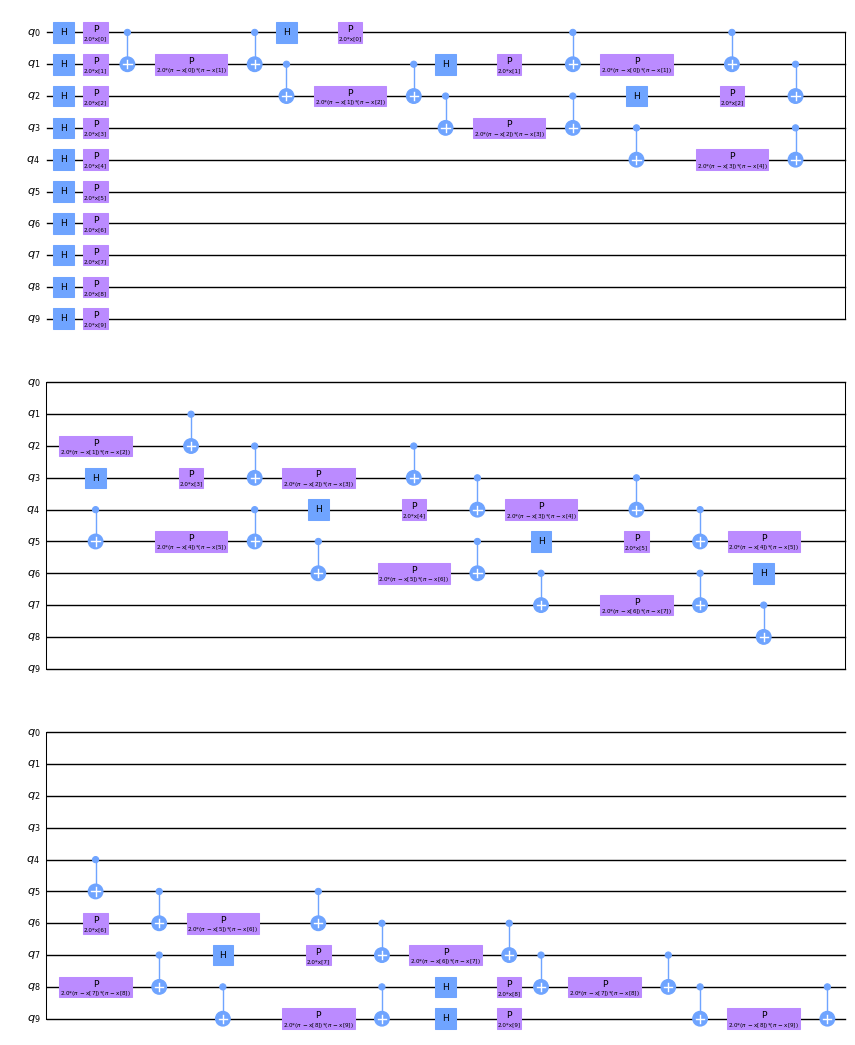

In [343]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(num_features, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw('mpl', scale=0.7)

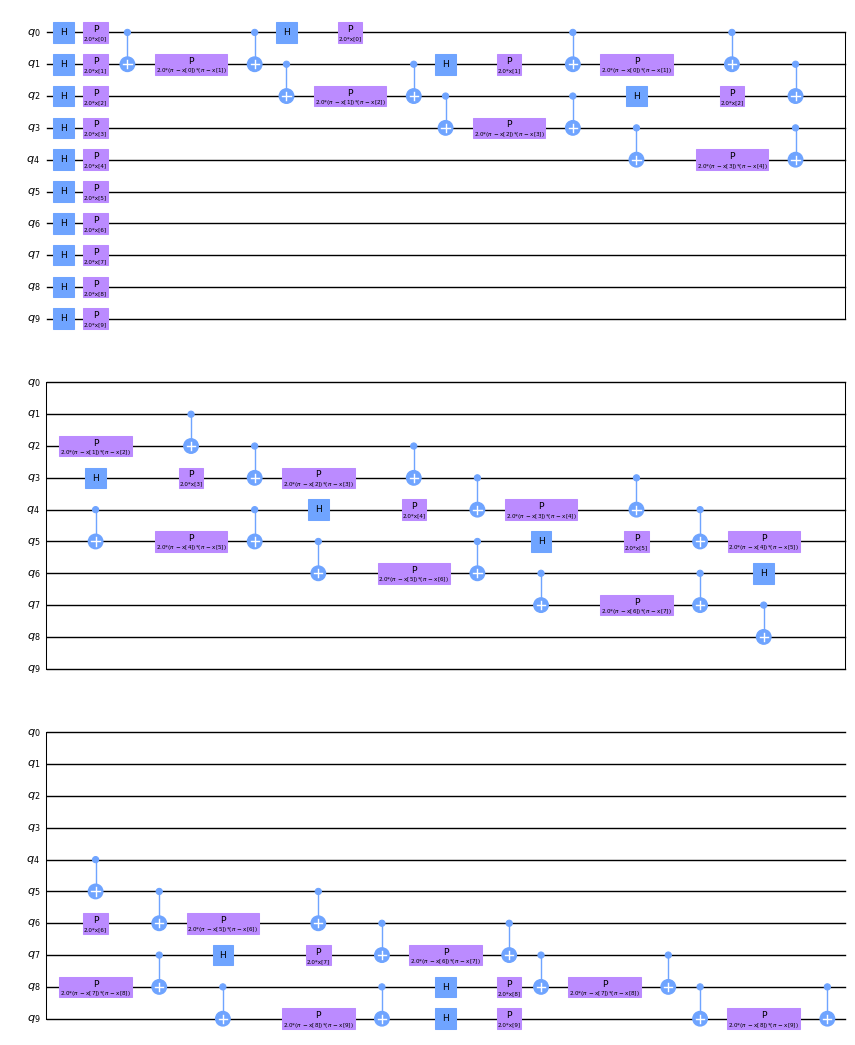

In [157]:
def get_pauli_feature_map(feature_dim, feature_map_rep, ent):
    # feature_map = PauliFeatureMap(..., paulis=["Z", "YY"], entanglement="full")
    return PauliFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_pauli = get_pauli_feature_map(num_features, 2, 'linear')
input_params = fmap_pauli.parameters
fmap_pauli.decompose().draw('mpl', scale=0.7)

/usr/local/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


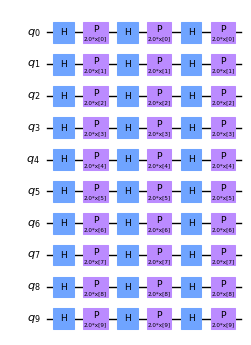

In [478]:
def get_pauli_feature_map(feature_dim, feature_map_rep, ent, paulis=["Z", "YY"]):
    # feature_map = PauliFeatureMap(..., paulis=["Z", "YY"], entanglement="full")
    return PauliFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, paulis=paulis, entanglement=ent)

# fmap_pauli = get_pauli_feature_map(num_features, 3, 'linear', paulis)
fmap_pauli = get_pauli_feature_map(num_features, 3, 'linear', paulis)
input_params = fmap_pauli.parameters
fmap_pauli.decompose().draw('mpl', scale=0.7)

In [479]:
# Ansatz

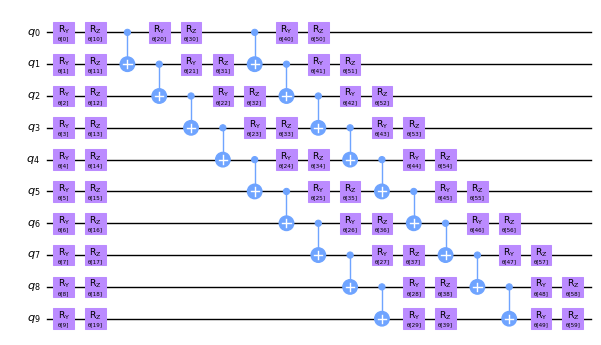

In [480]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw('mpl', scale=0.7)

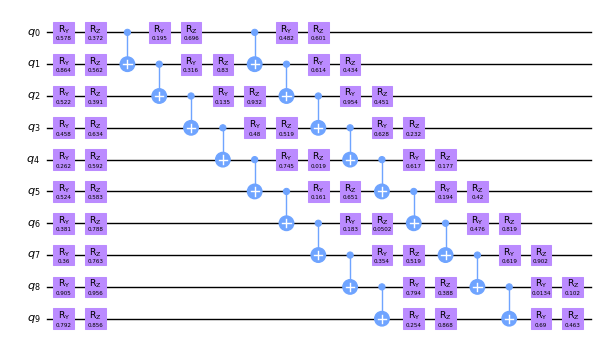

In [481]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

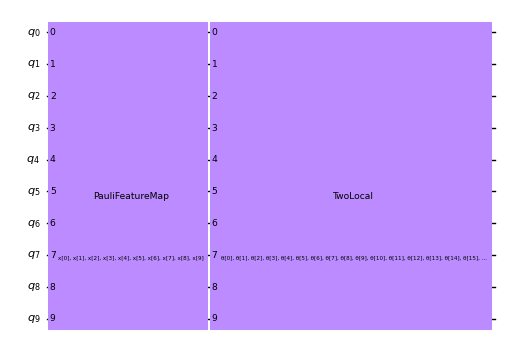

In [482]:
var_circuit = fmap_pauli.compose(ansatz_tl)
var_circuit.draw('mpl', scale=0.7)

In [483]:
# Primitives

In [484]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

In [485]:
# Q NN

In [486]:
# SamplerQNN

In [487]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [488]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [489]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

In [490]:
# Train a NN Classifier

In [491]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 1.0 converted to [0 1]
Label 0.0 converted to [1 0]


In [492]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [493]:
max_itr = 60
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(x_train, y_train_1h)

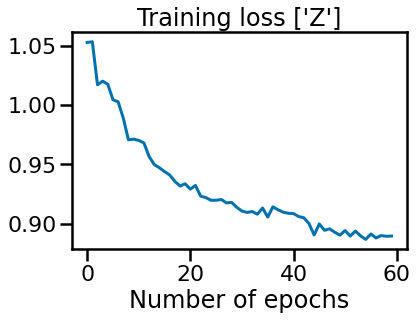

<Figure size 1440x576 with 0 Axes>

In [494]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title(f'Training loss {paulis}')
plt.figure(figsize=(20, 8))
plt.show()

In [290]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5750708215297451
Score on the test set 0.6404494382022472


In [298]:
y_train_pred = vqc.predict(x_train)
y_test_pred = vqc.predict(x_test)

In [246]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [247]:
x_all = np.concatenate((x_train, x_test))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [1, 0], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

x_r = x_all[np.all(y_all == [0, 1], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

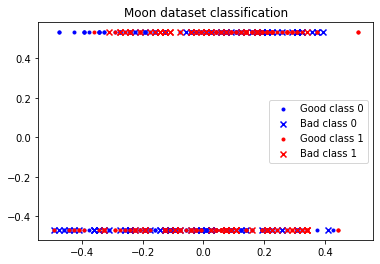

In [189]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Moon dataset classification")
plt.legend()

In [299]:
cm = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1))

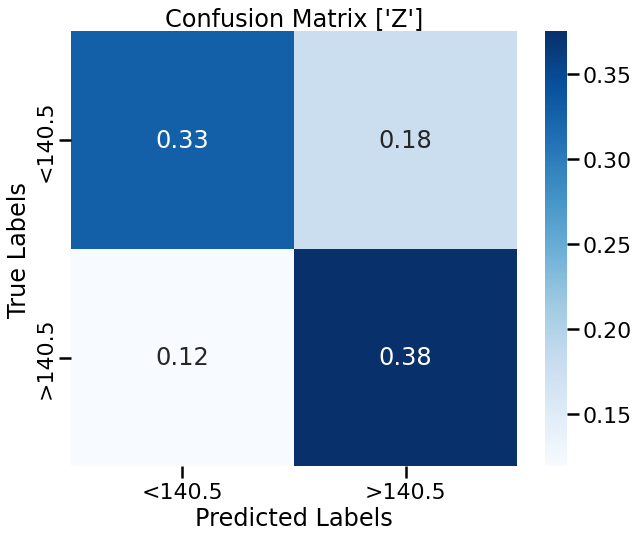

In [495]:
bs=5

y_train_pred = vqc.predict(x_train)
y_test_pred = vqc.predict(x_test)
cm = confusion_matrix(y_test, np.argmax(y_test_pred, axis=1))

for i in range(bs-1):
    y_train_pred = vqc.predict(x_train)
    y_test_pred = vqc.predict(x_test)
    cm = cm + confusion_matrix(y_test, np.argmax(y_test_pred, axis=1))
cm = cm / bs

# Plot using seaborn
cmNorm = cm / y_test_pred.shape[0]
plt.figure(figsize=(10, 8))
sns.heatmap(cmNorm, annot=True, cmap='Blues', xticklabels=[f'<{thrs}', f'>{thrs}'], yticklabels=[f'<{thrs}', f'>{thrs}'])
plt.title(f'Confusion Matrix {paulis}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


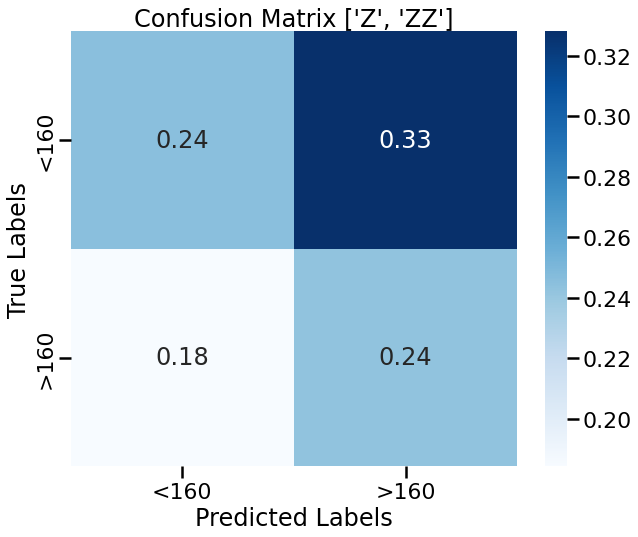

In [386]:
# Plot using seaborn
cmNorm = cm / y_test_pred.shape[0]
plt.figure(figsize=(10, 8))
sns.heatmap(cmNorm, annot=True, cmap='Blues', xticklabels=[f'<{thrs}', f'>{thrs}'], yticklabels=[f'<{thrs}', f'>{thrs}'])
plt.title(f'Confusion Matrix {paulis}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [178]:


# Fwd pass

# The result of the neural network on a forward pass.
output = sampler_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

# Bwd pass

# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")








# Estimator QNN

obs_parity = Pauli('Z' * num_features)
obs_one_qubit = Pauli('I' * (num_features - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}")

paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator)

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=var_circuit,
                             observables=obs_one_qubit,
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

# Fwd pass

# The result of the neural network on a forward pass.
output = estimator_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

# Bwd pass

# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")